# CNN Model Template

This notebook is a template for building a CNN model.

## Imports and inital setup

In [55]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

# import classweights
from sklearn.utils import class_weight

from time import sleep 

import cv2
import sys
import os

sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 856
NUM_EPOCHS = 20

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path
FIELPATH_TESTOUTPUT= "./../data/testoutput/"

TARGET_LABEL="dx_tertiary"

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 32

### Loading (augmented) metadata as test, train, validation from files

In [37]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

lesion_id                    image_id     dx    dx_type   age     sex   
1515  HAM_0006442            ISIC_0033295.jpg  akiec      histo  70.0    male  \
1432  HAM_0005275            ISIC_0028749.jpg    bkl      histo  65.0    male   
1447  HAM_0000893            ISIC_0032103.jpg    bkl      histo  70.0    male   
3008  HAM_0003827            ISIC_0028350.jpg    bcc      histo  70.0  female   
2820  HAM_0000247            ISIC_0025132.jpg    mel      histo  80.0    male   
5124  HAM_0005663  aug_MziEi6ISIC_0026417.jpg     df  consensus  30.0    male   
3314  HAM_0006115            ISIC_0025576.jpg    bcc      histo  55.0    male   
4305  HAM_0000494  aug_yBkv2IISIC_0033092.jpg   vasc      histo  55.0    male   
4935  HAM_0000349  aug_kAuhp0ISIC_0033005.jpg     df  consensus  45.0  female   
4704  HAM_0003023  aug_eA3tmzISIC_0031257.jpg     df  consensus  55.0  female   
1115  HAM_0003996            ISIC_0030383.jpg    bkl   confocal  80.0  female   
12    HAM_0001583            ISIC_0025280.jpg     nv  follow_up  35.0  female   
3924  HAM_0002914  aug_hua3jPISIC_0024904.jpg   vasc      histo  75.0    male   
2933  HAM_0003802            ISIC_0032308.jpg    mel      histo  75.0    male   
2798  HAM_0004596            ISIC_0031087.jpg    mel      histo  65.0    male   

         localization        dataset        dx_binary     dx_tertiary   
1515             hand   vidir_modern      skin_cancer       malignant  \
1432             face      rosendahl  not_skin_cancer  non-neoplastic   
1447  lower extremity      rosendahl  not_skin_cancer  non-neoplastic   
3008             back      rosendahl      skin_cancer       malignant   
2820             back      rosendahl      skin_cancer       malignant   
5124  lower extremity   vidir_modern  not_skin_cancer  non-neoplastic   
3314             back      rosendahl      skin_cancer       malignant   
4305  lower extremity   vidir_modern  not_skin_cancer  non-neoplastic   
4935  lower extremity   vidir_modern  not_skin_cancer  non-neoplastic   
4704  upper extremity  vidir_molemax  not_skin_cancer  non-neoplastic   
1115             face   vidir_modern  not_skin_cancer  non-neoplastic   
12              trunk  vidir_molemax  not_skin_cancer          benign   
3924  upper extremity   vidir_modern  not_skin_cancer  non-neoplastic   
2933             face   vidir_modern      skin_cancer       malignant   
2798  upper extremity      rosendahl      skin_cancer       malignant   

                                     image_path  
1515            ./../data/jpgs/ISIC_0033295.jpg  
1432            ./../data/jpgs/ISIC_0028749.jpg  
1447            ./../data/jpgs/ISIC_0032103.jpg  
3008            ./../data/jpgs/ISIC_0028350.jpg  
2820            ./../data/jpgs/ISIC_0025132.jpg  
5124  ./../data/jpgs/aug_MziEi6ISIC_0026417.jpg  
3314            ./../data/jpgs/ISIC_0025576.jpg  
4305  ./../data/jpgs/aug_yBkv2IISIC_0033092.jpg  
4935  ./../data/jpgs/aug_kAuhp0ISIC_0033005.jpg  
4704  ./../data/jpgs/aug_eA3tmzISIC_0031257.jpg  
1115            ./../data/jpgs/ISIC_0030383.jpg  
12              ./../data/jpgs/ISIC_0025280.jpg  
3924  ./../data/jpgs/aug_hua3jPISIC_0024904.jpg  
2933            ./../data/jpgs/ISIC_0032308.jpg  
2798            ./../data/jpgs/ISIC_0031087.jpg

## Setting up the image data generator for training and validation

In [38]:
def custom_preprocessing(np_image, image_size, show_image=False):
    # print the image
    # print("From custom_preprocessing: Image + shape before preprocessing:", np_image.shape)
    np_image = np_image.astype(np.uint8)
    
    #print(np_image)
    if show_image:
        plt.imshow(np_image.astype(np.uint8))
        plt.show()

    # rescale 
    np_image = np_image / 255.0

    # Using the image helper functions
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    
    if show_image:
        print("From custom_preprocessing: Image after center crop:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image

    if show_image:
        print("From custom_preprocessing: Image after after resizing:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    return np_image

In [39]:
#print("sample augmented image from HDD:")
sample_img_path = "./../data/jpgs/aug_s8yXnVISIC_0030555.jpg"
sample_img = plt.imread(sample_img_path)

# normalize the pixel values as it would happen in the model
#sample_img = sample_img / 255.0

processed_img = custom_preprocessing(sample_img, IMAGE_SIZE, show_image=False) 

#print("sample orig image from HDD:")
sample_img_path = "./../data/jpgs/ISIC_0030571.jpg"
sample_img = plt.imread(sample_img_path)

# normalize the pixel values as it would happen in the model

processed_img = custom_preprocessing(sample_img, IMAGE_SIZE, show_image=False)

In [40]:
# Setting up the Image Data Generator for the train data set

datagen_train = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
)

datagen_validation = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

train_data_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    color_mode='rgb',
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    #save_to_dir=FILEPATH_OUTPUT,
    #save_prefix="test_gen_",
    #save_format="jpg",
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 5254 validated image filenames belonging to 3 classes.
Found 1001 validated image filenames belonging to 3 classes.


In [41]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen)  
    plt.figure(figsize=(25, 25))
    length = len(labels)
    if length < 25:  
        r = length
    else:
        r = 25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i]  
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

In [42]:
images, labels = next(train_data_generator)
print(images.min(), images.max(), images.dtype)

0.0 1.0 float32


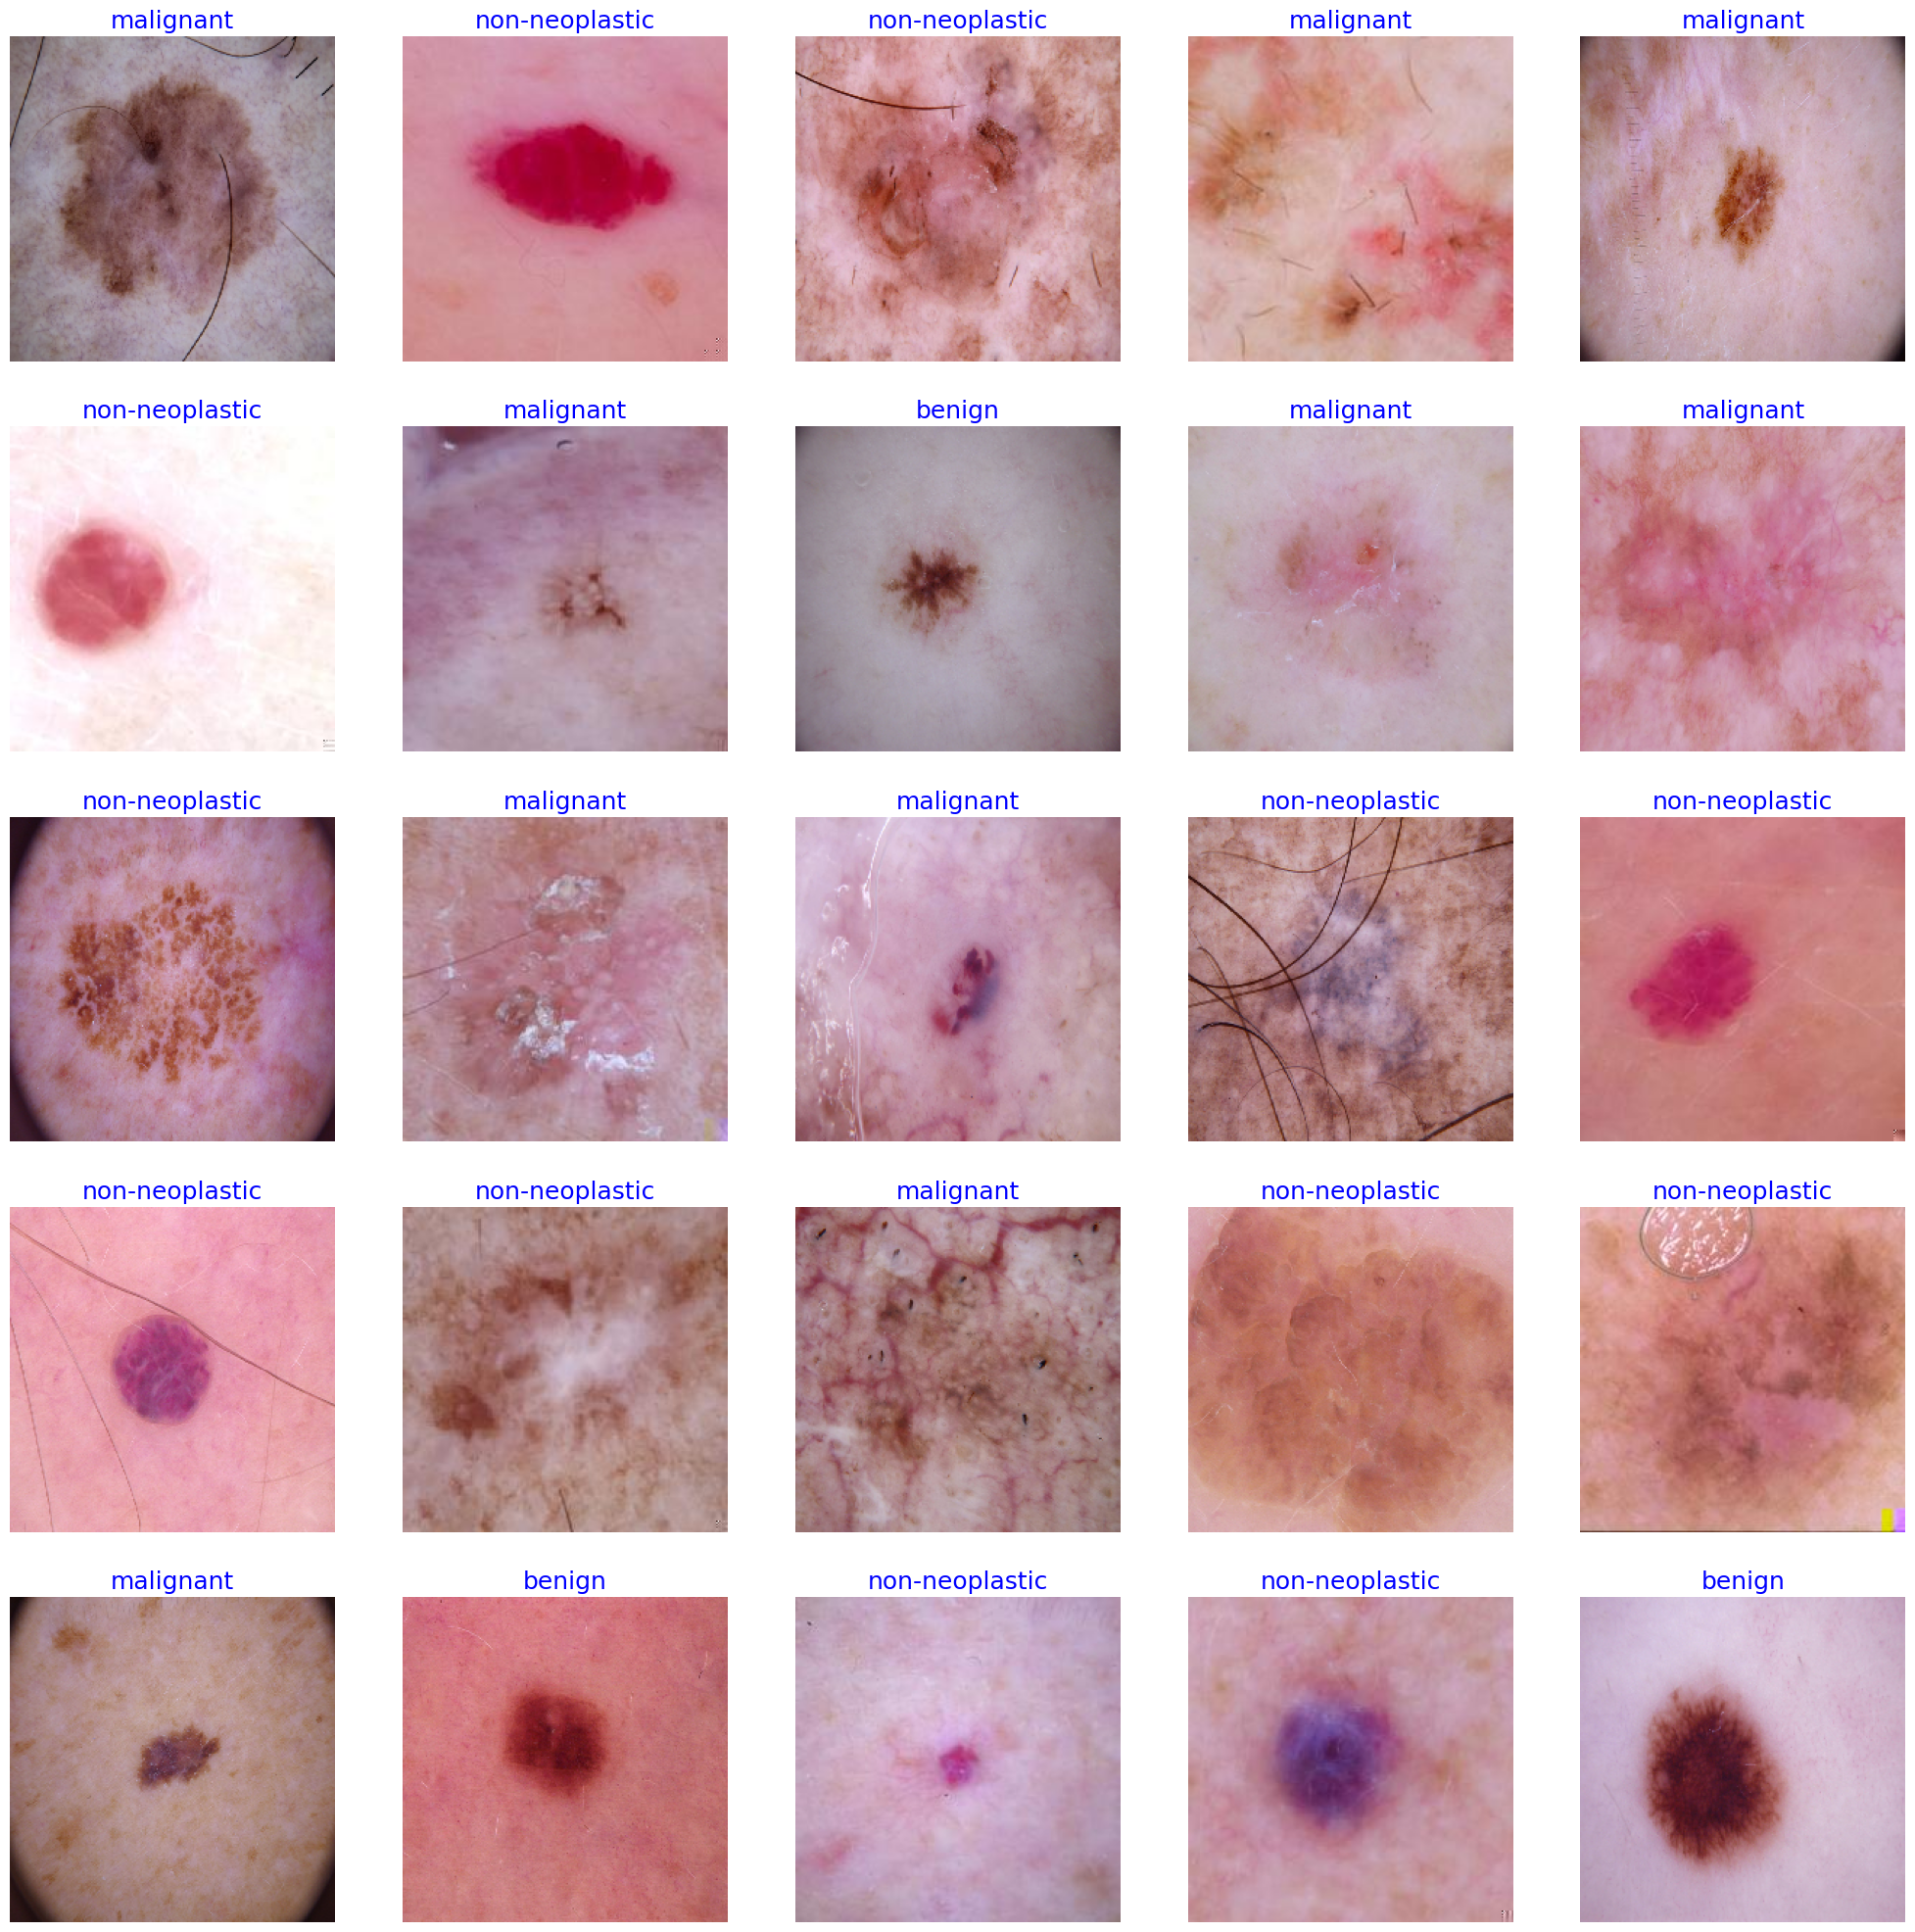

In [43]:
show_image_samples(train_data_generator)

# Using MobileNet V3 large

In [56]:
# calculating class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    np.unique(train_data_generator.classes), 
    train_data_generator.classes)

print("class weights:", class_weights)

TypeError: compute_class_weight() takes 1 positional argument but 3 were given

In [44]:
def f1_score(y_true, y_pred):
    # Calculate precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculate recall
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    # Calculate F1 score
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [45]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

In [46]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.00001)

In [47]:
PRETRAINED = False

if PRETRAINED:
    # Initialize the MobileNetV3Large model
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    print(base_model.output_shape)

    # Freeze the base model's layers to use it for feature extraction
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top 
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(base_model.output)

    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)

    # Global average pooling instead of flattening
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(128, activation='relu')(x)

    x = layers.Dropout(0.5)(x)  # 50% dropout /new

    x = layers.Dense(train_df[TARGET_LABEL].nunique(), activation='softmax')(x) 

    # Create the full model
    model = Model(inputs=base_model.input, outputs=x, name="MobilneNetV3Large_pretrained-weights_binary_fixed-layers_custom-conv2D")

    # Setting an optimizer
    opt = SGD(learning_rate=0.0001, 
                momentum=0.9
                # nesterov=True,
                # decay=0.01
              )

    # Compile the model
    model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                #loss = focal_loss(),
                metrics=[
                        #Recall(), 
                        #Precision(), 
                        'accuracy',
                        f1_score
                        ])

    model.summary()

else:
    # Initialize the MobileNetV3Large model
    base_model = MobileNetV3Large(weights=None, include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # Freeze the base model's layers to use it for feature extraction
    for layer in base_model.layers:
        layer.trainable = True

    # Add custom layers on top 
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(base_model.output)

    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)

    # Global average pooling instead of flattening
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(128, activation='relu')(x)

    x = layers.Dropout(0.5)(x)  # 50% dropout /new

    x = layers.Dense(train_df[TARGET_LABEL].nunique(), activation='softmax')(x) 

    # Create the full model
    model = Model(inputs=base_model.input, outputs=x, name="MobilneNetV3Large_rand-weights")

    # Setting an optimizer
    opt = SGD(learning_rate=0.0001, 
                momentum=0.9
                # nesterov=True,
                # decay=0.01
              )
    
    model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                #loss = focal_loss(),
                metrics=[
                        #Recall(), 
                        #Precision(), 
                        'accuracy',
                        f1_score
                        ])

    model.summary()


Model: "MobilneNetV3Large_rand-weights"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_2[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                           

## Model Training

In [48]:
import matplotlib.pyplot as plt

class ImageDisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, generator, num_samples=5):
        super(ImageDisplayCallback, self).__init__()
        self.generator = generator
        self.num_samples = num_samples

    def on_epoch_begin(self, epoch, logs=None):
        # Get a batch of images and labels
        images, _ = next(self.generator)


        # Display the first few images from the batch
        for i in range(min(self.num_samples, len(images))):
            #plt.imshow(images[i][:, :, ::-1] * 255)  # This will flip the channels
            img = np.clip(images[i]*255, 0, 255).astype('uint8')
            plt.imshow(img)
            plt.title(f"Sample {i+1} at Epoch {epoch+1}")
            plt.axis('off')
            plt.show()


In [49]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

class ImageComparisonCallback(Callback):
    def __init__(self, generator, base_dir):
        super(ImageComparisonCallback, self).__init__()
        self.generator = generator
        self.base_dir = base_dir

    def on_epoch_begin(self, epoch, logs=None):
        # Reset the generator
        self.generator.reset()

        # Get the first batch of images from the generator
        img_gen_batch, _ = next(self.generator)
        
        # Get the index of the first image in this batch relative to self.generator.filenames
        idx = self.generator.index_array[0]
        
        # Pick the image from the batch using this index and its corresponding filename
        img_gen_array = img_gen_batch[0]
        filename = self.generator.filenames[idx]

        # Load the corresponding image from disk
        img_path = os.path.join(self.base_dir, filename)
        img_disk = image.load_img(img_path, target_size=self.generator.image_shape[:2])
        img_disk_array = image.img_to_array(img_disk)

        # Compare the two arrays
        is_same = np.array_equal(img_disk_array, img_gen_array)
        if is_same:
            print("The images are identical!")
        else:
            print("The images are different!")
            np.array_diff = img_disk_array - img_gen_array

        # Display both images for comparison
        fig, axes = plt.subplots(1, 2, figsize=(8, 3))
        axes[0].imshow(img_disk_array.astype('uint8'))
        axes[0].set_title(f'Image from Disk: {filename}')
        axes[0].axis('off')

        # If the generator normalizes images to [0,1], we multiply by 255 for proper visualization
        axes[1].imshow((img_gen_array*255).astype('uint8'))
        axes[1].set_title('Image from Generator')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

# Usage: Assuming you have already defined a generator, `train_generator`, and a base directory, `data_dir`
# callback = ImageComparisonCallback(train_generator, data_dir)

base_dir = FILEPATH_JPGS

In [50]:
# Train the model

history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,              
    verbose=1,                      # Adjust verbosity level
    batch_size=BATCH_SIZE,                # Set the batch size, default is 32, can be increased to speed up training
    callbacks=[
        reduce_lr 
        #ImageComparisonCallback(generator=train_data_generator, base_dir=base_dir)
        ],                 # List of callbacks to apply during training 
    #validation_split=0.0,           # not needed as we use a validation data generator
    validation_data=validation_generator,
    shuffle=True,                   # Shuffle the training data before each epoch
    #sample_weight=None,             # Set the weights for the train data set !
    class_weight=None,              # Set the weights for the classes, not needed if we use sample weights
    initial_epoch=0,                # Use this to continue training from a specific epoch
    steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
    validation_steps=None,          # Set the number of steps for validation, default is len(x_val) // batch_size
    #validation_batch_size=None,     # Set the batch size for validation, default is batch_size
    validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
    max_queue_size=10,              # Set the max size for the generator queue
    workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
    use_multiprocessing=False       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
)

Epoch 1/20


165/165 [==============================] - 1064s 6s/step - loss: 1.0444 - accuracy: 0.4244 - f1_score: 0.0535 - val_loss: 1.1145 - val_accuracy: 0.1948 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/20
165/165 [==============================] - 511s 3s/step - loss: 1.0085 - accuracy: 0.4473 - f1_score: 0.1104 - val_loss: 1.1199 - val_accuracy: 0.1948 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/20
165/165 [==============================] - 401s 2s/step - loss: 0.9912 - accuracy: 0.4614 - f1_score: 0.1522 - val_loss: 1.1234 - val_accuracy: 0.1948 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/20
165/165 [==============================] - ETA: 0s - loss: 0.9759 - accuracy: 0.4754 - f1_score: 0.2137
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
165/165 [==============================] - 358s 2s/step - loss: 0.9759 - accuracy: 0.4754 - f1_score: 0.2137 - val_loss: 1.1238 - val_accuracy: 0.1948 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch

## Plotting accuracy and loss of train and validation set

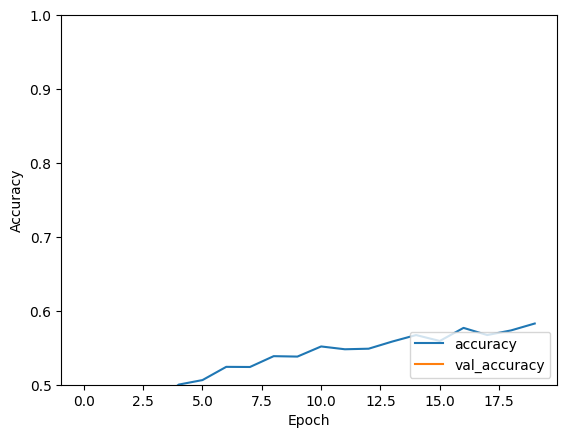

In [54]:
mh.model_plot_accuracy(history)

## Evaluating the model on the test set

 > Evaluating model MobilneNetV3Large_rand-weights:
 > Loading test images...


 > Test images loaded.


 > Converting labels to one hot format...
 > Getting model predictions...
32/32 [==============================] - 10s 280ms/step
 > Model predictions obtained.
 > Macro AUC: 0.5278029757343856
 > Micro AUC: 0.24196442444452415


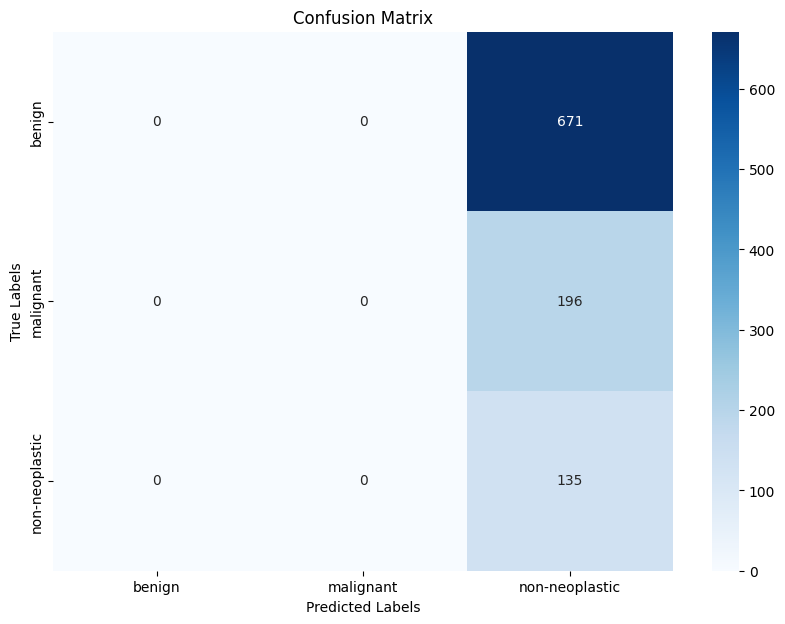



 > Computing classification report...
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       671
           1       0.00      0.00      0.00       196
           2       0.13      1.00      0.24       135

    accuracy                           0.13      1002
   macro avg       0.04      0.33      0.08      1002
weighted avg       0.02      0.13      0.03      1002

 > Evaluating model on test set...


/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

32/32 [==============================] - 9s 284ms/step - loss: 1.1356 - accuracy: 0.1347 - f1_score: 0.0000e+00
loss: 1.1355564594268799
accuracy: 0.1347305327653885
f1_score: 0.0
 > Done.


([{'loss': 1.1355564594268799},
  {'accuracy': 0.1347305327653885},
  {'f1_score': 0.0}],
 array([[  0,   0, 671],
        [  0,   0, 196],
        [  0,   0, 135]]),
 (0.24196442444452415, 0.5278029757343856))

In [52]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [53]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)

/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
